In [1]:
import logging, json
import numpy as np
import pandas as pd

from apsopt.core.optimizer import Optimizer, get_generator_class
from apsopt.core.evaluators import FunctionEvaluator
from apsopt.util.pydantic.options import AlgorithmOptions
from apsopt.util.pydantic.vocs import GVOCS

from opt_funcs_nsls import make_dummy_eval, make_dummy_eval_lifetime

logger = logging.getLogger(__name__)

In [2]:
MODE = '6and3'
with open(f'lattice/data_{MODE}.json', 'r') as f:
    data_dict = json.load(f)
groups = data_dict['groups']
groups_direct = data_dict['groups_direct']
all_groups = {**groups, **groups_direct}
indices = data_dict['indices']
null_knobs = data_dict['null_knobs']
dfknobs = pd.read_json(f'lattice/dfknobs_{MODE}.json')

In [3]:
# impact of K2L difference
dfknobs.loc['SM2B',:] *= 0.25/0.2

In [4]:
dfknobs

,SVD0,SH1,SH3,SH4,SL1,SL2,SL3
SL1,0.000000,0,0,0,1,0,0
SL2,0.000000,0,0,0,0,1,0
SL3,0.000000,0,0,0,0,0,1
SH1,0.000000,1,0,0,0,0,0
SH3,0.000000,0,1,0,0,0,0
SH4,0.000000,0,0,1,0,0,0
SM1A,-0.663666,0,0,0,0,0,0
SM1B,0.744816,0,0,0,0,0,0
SM2B,-0.086576,0,0,0,0,0,0


This notebook uses:
- Absolute K2L offsets per knob as variables
- Absolute K2L values per family as inputs to the evaluation function
- Lifetime as the objective

SETUP SINGLE-OBJECTIVE RUN (i.e. only lifetime)

In [5]:
# DO NOT CHANGE - USED TO CALCULATE ABSOLUTE K2L
initial_values_ref = {
    'SM1A': -23.68063424*0.2,
    'SM2B': 28.64315469*0.25,
    'SM1B': -25.94603546*0.2,
    'SL3': -29.46086061*0.2,
    'SL2': 35.67792145*0.2,
    'SL1': -13.27160605*0.2,
    'SH4': -15.82090071*0.2,
    'SH3': -5.85510841*0.2,
    'SH1': 19.8329121*0.2,
}

# CHANGE THIS TO VALUES FROM RING IF NEEDED
initial_values = initial_values_ref.copy()

# optimizer variables in units of K2L
variables = {'SVD0':[-0.6,0.6]} # this means SM1B will change by ~10%
             
for k in ['SH1','SH3','SH4','SL1','SL2','SL3']:
    variables[k] = [-np.abs(initial_values_ref[k])*0.1,np.abs(initial_values_ref[k])*0.1]

objectives_active = {'LT':'MAXIMIZE'}

initial_variable_values = {k:0.0 for k in variables.keys()}

gvocs = GVOCS(variables=variables,
              variables_active=variables,
              objectives=objectives_active,
              objectives_active=objectives_active)

print(pd.DataFrame(initial_values_ref,index=[0]))
print(pd.DataFrame(variables))

       SM1A      SM2B      SM1B       SL3       SL2       SL1      SH4  \
0 -4.736127  7.160789 -5.189207 -5.892172  7.135584 -2.654321 -3.16418   

        SH3       SH1  
0 -1.171022  3.966582  
   SVD0       SH1       SH3       SH4       SL1       SL2       SL3
0  -0.6 -0.396658 -0.117102 -0.316418 -0.265432 -0.713558 -0.589217
1   0.6  0.396658  0.117102  0.316418  0.265432  0.713558  0.589217


In [6]:
import sext_tools
def compute_family_k2l_from_knob_k2l(dfknobs, knobs_dict, debug=False):
    group_relative_strengths = sext_tools.knob_strengths_to_group_strengths(dfknobs, knobs_dict)
    for k in group_relative_strengths:
        if debug:
            print(f'{k}: {initial_values[k]:.3f} + {group_relative_strengths[k]:.3f} -> {initial_values[k]+group_relative_strengths[k]:.3f}')
        group_relative_strengths[k] = group_relative_strengths[k] + initial_values[k]        
    return group_relative_strengths

In [7]:
compute_family_k2l_from_knob_k2l(dfknobs, {k:variables[k][0] for k in variables.keys()}, True)

SL1: -2.654 + -0.265 -> -2.920
SL2: 7.136 + -0.714 -> 6.422
SL3: -5.892 + -0.589 -> -6.481
SH1: 3.967 + -0.397 -> 3.570
SH3: -1.171 + -0.117 -> -1.288
SH4: -3.164 + -0.316 -> -3.481
SM1A: -4.736 + 0.398 -> -4.338
SM1B: -5.189 + -0.447 -> -5.636
SM2B: 7.161 + 0.052 -> 7.213


{'SL1': -2.9197533310000003,
 'SL2': 6.422025861000001,
 'SL3': -6.481389334200001,
 'SH1': 3.5699241780000004,
 'SH3': -1.2881238501999999,
 'SH4': -3.4805981562,
 'SM1A': -4.33792749214,
 'SM1B': -5.6360967334600005,
 'SM2B': 7.2127339758749995}

In [8]:
eval_f = make_dummy_eval_lifetime(gvocs)
ev = FunctionEvaluator(script=eval_f)

generator_name = 'bo_ucb'
gc = get_generator_class(generator_name)

gen = gc(gvocs=gvocs)
gen.numerical_optimizer.n_raw_samples = 512
gen.numerical_optimizer.n_restarts = 10
gen.gp_constructor.use_low_noise_prior = False

In [9]:
options = AlgorithmOptions(store_history=True, dump_every_step=True)
opt = Optimizer(options=options,
                generator=gen,
                evaluator=ev,
                gvocs=gvocs)

Sample at initial values (i.e. standard lattice)

In [10]:
opt.generate_at(initial_variable_values)
opt.evaluate_data()

In [11]:
opt.data

,SVD0,SH1,SH3,SH4,SL1,SL2,SL3,result,exception,traceback,wall_time,cpu_time,valid,LT
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,{'LT': 4.730315625429988},None,,0.000062,0.0,True,4.730316


Sample close to initial point

In [12]:
mt = {k: 0.05 for k in variables.keys()}
opt.generate_random_around_point(n=1, point=initial_variable_values, spans=mt, use_normalized_distances=True)
opt.evaluate_data()

In [13]:
opt.data

,SVD0,SH1,SH3,SH4,SL1,SL2,SL3,result,exception,traceback,wall_time,cpu_time,valid,LT
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,{'LT': 4.730315625429988},None,,0.000062,0.0,True,4.730316
2,0.015927,0.017124,0.005272,0.008148,-0.009621,0.028042,0.007175,{'LT': 4.729740273681895},None,,0.000056,0.0,True,4.729740


Run optimizer

In [14]:
import warnings
#warnings.filterwarnings("ignore", message="Unable to find non-zero acquisition function values")

for i in range(50):
    opt.step()

In [15]:
opt.data.tail()

,SVD0,SH1,SH3,SH4,SL1,SL2,SL3,result,exception,traceback,wall_time,cpu_time,valid,LT
48,0.287620,0.396658,0.039765,0.268753,0.265432,0.375998,0.396705,{'LT': 9.043553068851137},None,,0.000042,0.0,True,9.043553
49,0.309424,0.396658,0.041595,0.316418,0.265432,0.407033,0.418049,{'LT': 9.390029308752826},None,,0.000046,0.0,True,9.390029
50,0.326064,0.396658,0.043651,0.316418,0.265432,0.436214,0.430316,{'LT': 9.265122894659433},None,,0.000050,0.0,True,9.265123
51,0.336760,0.396658,0.044755,0.316418,0.265432,0.452085,0.436194,{'LT': 9.068660498430217},None,,0.000056,0.0,True,9.068660
52,0.309465,0.396658,0.040738,0.316418,0.265432,0.423015,0.419608,{'LT': 9.031908173927084},None,,0.000048,0.0,True,9.031908


Text(0, 0.5, 'Objective')

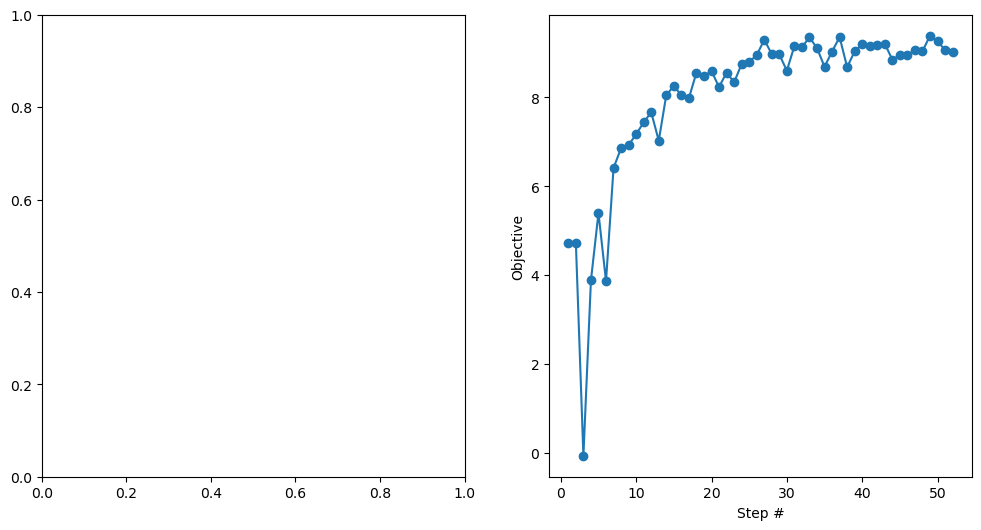

In [20]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,2,squeeze=False,figsize=(12,6))
df = opt.data
ol = ['LT']

ax[0,1].plot(df.loc[:,gvocs.objective_names_active[0]],marker='o')
ax[0,1].set_xlabel('Step #')
ax[0,1].set_ylabel('Objective')

In [ ]:
# This will save optimizer state
opt.state_to_json('sobo_dump.json')

import os
os.remove('sobo_dump.json')